In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from pprint import pprint
     

In [2]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [4]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2024-03-26 18:19:13--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  1.75MB/s    in 2.7s    

2024-03-26 18:19:16 (1.75 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [5]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))
     

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [6]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head() 

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [8]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Merging required datasets

In [10]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [11]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [13]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [14]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [15]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [16]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


## Splitting the data into training and testing

In [17]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

### Defining number of factors which are to be considered by the Embedding layer

In [18]:
n_factors = 150

In [19]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [20]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

In [21]:
#Normalizing
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

### Building a Softmax Deep Neural Network

In [23]:
from tensorflow.python.keras.layers import Input, Dense, Embedding
from tensorflow.keras.models import Model

In [24]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 1)            0           ['input_2[0][0]']                
                                                                                                  
 tf.cast_1 (TFOpLambda)         (None, 1)            0           ['input_3[0][0]']                
                                                                                              

In [28]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/20
701/701 [==============================] - 1s 1ms/step - loss: 0.5261 - accuracy: 0.0609 - val_loss: 0.5111 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/20
701/701 [==============================] - 1s 910us/step - loss: 0.5238 - accuracy: 0.0609 - val_loss: 0.5103 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/20
701/701 [==============================] - 1s 922us/step - loss: 0.5215 - accuracy: 0.0609 - val_loss: 0.5107 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/20
701/701 [==============================] - 1s 946us/step - loss: 0.5208 - accuracy: 0.0609 - val_loss: 0.5097 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/20
701/701 [==============================] - 1s 894us/step - loss: 0.5203 - accuracy: 0.0609 - val_loss: 0.5096 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/20
701/701 [==============================] - 1s 924us/step - loss: 0.5197 - accuracy: 0.0609 - val_loss: 0.5095 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/20
701/701 [==============================] - 1s 1ms

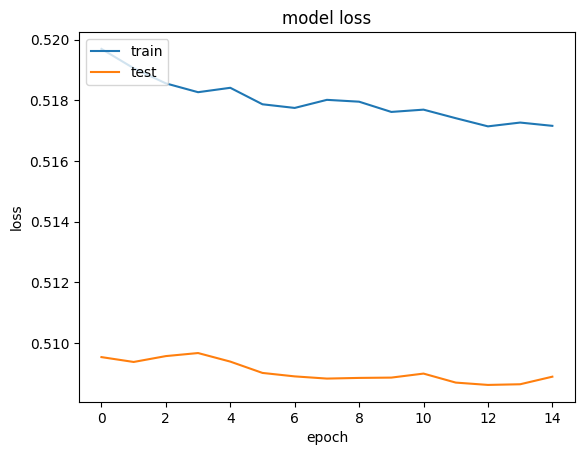

In [29]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [31]:
def recommender_system(user_id=1, model=model, n_movies=10):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [32]:
recommender_system()


Movie seen by the User:
['101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 'Abyss, The (1989)',
 'Ace Ventura: Pet Detective (1994)',
 'Air Bud (1997)',
 'Akira (1988)',
 'Aladdin (1992)',
 'Alien (1979)',
 'Aliens (1986)',
 'All Dogs Go to Heaven 2 (1996)',
 'Amadeus (1984)',
 'Angels and Insects (1995)',
 "Antonia's Line (1995)",
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Aristocats, The (1970)',
 'Army of Darkness (1993)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Bad Boys (1995)',
 'Basic Instinct (1992)',
 'Batman & Robin (1997)',
 'Batman Forever (1995)',
 'Batman Returns (1992)',
 'Beavis and Butt-head Do America (1996)',
 'Bedknobs and Broomsticks (1971)',
 'Belle de jour (1967)',
 'Big Night (1996)',
 'Billy Madison (1995)',
 'Birdcage, The (1996)',
 'Blade Runner (1982)',
 'Blues Brothers, The (1980)',
 'Bound (1996)',
 "Bram Stoker's Dr